In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/hateful_memes/hateful_memes_original.csv')
image_dir = '/content/drive/MyDrive/hateful_memes/img'

Dataset Description

In [ ]:
df.head()

,text,img,label
0,a school bus that was engulfed in flames,img/32674.png,0
1,when you ask your dad who is a retired drill s...,img/10246.png,1
2,how i see kim burell everytime she grabs a mic!,img/14570.png,1
3,doing o's with the smoke,img/05316.png,0
4,im gettin white girl wasted tonight,img/20936.png,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    10000 non-null  object
 1   img     10000 non-null  object
 2   label   10000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 234.5+ KB


In [ ]:
df.drop_duplicates(inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    10000 non-null  object
 1   img     10000 non-null  object
 2   label   10000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 234.5+ KB


Text preprocessing using Tokenizer

In [ ]:

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['text'])
sequences = tokenizer.texts_to_sequences(df['text'])
word_index = tokenizer.word_index
max_sequence_length = max([len(seq) for seq in sequences])
text_data = pad_sequences(sequences, maxlen=max_sequence_length)

Image preprocessing

In [ ]:
image_data = []
valid_indices = []
for idx, image_file in enumerate(os.listdir(image_dir)):
    if image_file.endswith('.png'):
        img_path = os.path.join(image_dir, image_file)
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = preprocess_input(img_array)
        image_data.append(img_array)
        valid_indices.append(idx)
image_data = np.array(image_data)

In [ ]:
text_data_filtered = text_data[valid_indices]
y_filtered = df['label'].iloc[valid_indices]

In [ ]:
X_text = text_data_filtered
X_image = image_data
y = y_filtered.values

In [ ]:
X_text_train, X_text_test, X_image_train, X_image_test, y_train, y_test = train_test_split(
    X_text, X_image, y, test_size=0.2, random_state=42)
X_text_train, X_text_val, X_image_train, X_image_val, y_train, y_val = train_test_split(
    X_text_train, X_image_train, y_train, test_size=0.1, random_state=42)

Defining ResNET 50  model architecture

In [ ]:
text_input = layers.Input(shape=(max_sequence_length,), name='text_input')
text_embedding = layers.Embedding(len(word_index) + 1, 100, input_length=max_sequence_length)(text_input)
text_flatten = layers.Flatten()(text_embedding)

image_input = layers.Input(shape=(224, 224, 3), name='image_input')
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
image_output = base_model(image_input)
image_flatten = layers.Flatten()(image_output)

concatenated = layers.concatenate([text_flatten, image_flatten])
output = layers.Dense(1, activation='sigmoid')(concatenated)

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
model = Model(inputs=[text_input, image_input], outputs=output)

Model Training

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit([X_text_train, X_image_train], y_train, validation_data=([X_text_val, X_image_val], y_val), epochs=10, batch_size=32)

Epoch 1/10
69/69 [==============================] - 1865s 27s/step - loss: 2.3896 - accuracy: 0.5852 - val_loss: 5406.7153 - val_accuracy: 0.6122
Epoch 2/10
69/69 [==============================] - 1834s 27s/step - loss: 1.0522 - accuracy: 0.6280 - val_loss: 22.0468 - val_accuracy: 0.6082
Epoch 3/10
69/69 [==============================] - 1784s 26s/step - loss: 0.6331 - accuracy: 0.7391 - val_loss: 2.1582 - val_accuracy: 0.5265
Epoch 4/10
69/69 [==============================] - 1715s 25s/step - loss: 0.5437 - accuracy: 0.8506 - val_loss: 0.8670 - val_accuracy: 0.5633
Epoch 5/10
69/69 [==============================] - 1694s 25s/step - loss: 0.3645 - accuracy: 0.9030 - val_loss: 2.1191 - val_accuracy: 0.4816
Epoch 6/10
69/69 [==============================] - 1695s 25s/step - loss: 0.2139 - accuracy: 0.9317 - val_loss: 0.8870 - val_accuracy: 0.5959
Epoch 7/10
69/69 [==============================] - 1674s 24s/step - loss: 0.1662 - accuracy: 0.9545 - val_loss: 1.1787 - val_accuracy: 0.

In [ ]:
loss, accuracy = model.evaluate([X_text_test, X_image_test], y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

20/20 [==============================] - 128s 6s/step - loss: 0.9612 - accuracy: 0.6498
Test Loss: 0.9611522555351257, Test Accuracy: 0.649754524230957


In [ ]:
y_pred_prob = model.predict([X_text_test, X_image_test])

20/20 [==============================] - 129s 6s/step


In [ ]:
y_pred = (y_pred_prob > 0.5).astype(int)

In [ ]:
y_pred

array([[0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
    

Performance Metrics

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

In [ ]:
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_prob)

print(f'Precision: {precision}, Recall: {recall}, F1-score: {f1}, AUC: {auc}')

Precision: 0.4973821989528796, Recall: 0.4460093896713615, F1-score: 0.4702970297029703, AUC: 0.6200721919456437


In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)

In [ ]:
print(conf_matrix)

[[302  96]
 [118  95]]


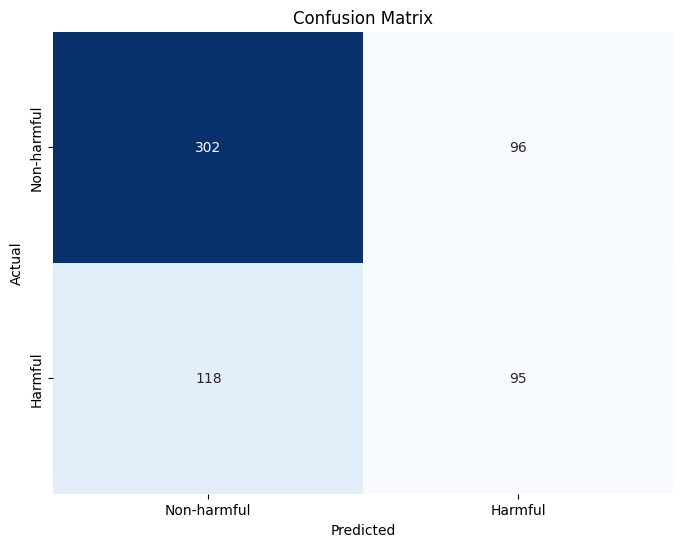

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', cbar=False,
            xticklabels=['Non-harmful', 'Harmful'], yticklabels=['Non-harmful', 'Harmful'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()